In [ ]:
import tensorflow as tf
import os

In [ ]:
## limit the gpu using
gpus = tf.config.experimental.list_physical_devices('GPU')
for gpu in gpus:
    tf.config.experimental.set_memory_growth(gpu, True)


In [ ]:
import kagglehub

In [ ]:
# Download latest version
path = kagglehub.dataset_download("paultimothymooney/chest-xray-pneumonia")

In [ ]:
print("Path to dataset files:", path)

Path to dataset files: /kaggle/input/chest-xray-pneumonia


In [ ]:
import os
os.listdir(path)

['chest_xray']

In [ ]:
import torch
print("PyTorch version:", torch.__version__)
import tensorflow as tf
print("TensorFlow version:", tf.__version__)

PyTorch version: 2.6.0+cu124
TensorFlow version: 2.18.0


In [ ]:
class DATALOAD:
  def __init__(self, flagging):
    self.flagging = flagging
    self.mri = "uraninjo/augmented-alzheimer-mri-dataset-v2"
    self.xray = "paultimothymooney/chest-xray-pneumonia"
    self.data_dir = self.get_data_dir()
    self.input_img_size = 224
    self.batch_size = 10
    self.train_ds, self.val_ds = self.load_data()

  def get_data_dir(self):
    if self.flagging == "mri":
      path = kagglehub.dataset_download(self.mri)
      path =  os.path.join(path, 'data')
    else:
      path = kagglehub.dataset_download(self.xray)
      path= os.path.join(path, 'chest_xray')
    return path

  def data_load(self, dir):
    data = tf.keras.preprocessing.image_dataset_from_directory(
        dir,
        image_size=(self.input_img_size, self.input_img_size),
        batch_size =self.batch_size,
        labels='inferred',
        label_mode='categorical',  # for one-hot encoding; use 'int' if you prefer integers
        shuffle=True,
        seed=42)
    return data

  def load_data(self):
    train_ds = self.data_load(self.data_dir + '/train')
    val_ds = self.data_load(self.data_dir + '/val')
    return train_ds, val_ds

In [ ]:
xu = DATALOAD("mri")

100%|██████████| 379M/379M [00:09<00:00, 40.9MB/s]

Extracting files...


Found 33984 files belonging to 4 classes.
Found 6400 files belonging to 4 classes.


In [ ]:
# xu.train_ds, xu.val_ds

In [ ]:
# xu = DATALOAD("xray")

In [ ]:
# xu.train_ds, xu.val_ds

In [ ]:
# xu.train_ds.class_names

In [ ]:
import torch
device = "cuda" if torch.cuda.is_available() else "cpu"
batch_size = 42
num_classes = len(xu.train_ds.class_names)
learning_rate = 1e-3
epochs = 5
learning_rate = 1e-4
img_size = 224  # resize for ResNet

In [ ]:
import tensorflow as tf
from tensorflow.keras.applications import ResNet50
from tensorflow.keras import layers, models
from tensorflow.keras.callbacks import ModelCheckpoint

In [ ]:
# Function to add the final layers on top of ResNet50
def end_layer(base_model):
    model_res = models.Sequential([
        base_model,
        layers.GlobalAveragePooling2D(),
        layers.Dense(256, activation='relu'),
        layers.Dropout(0.5),
        layers.Dense(num_classes, activation='softmax')
    ])
    model_res.compile(
        optimizer='adam',
        loss='categorical_crossentropy',
        metrics=['accuracy']
    )

    model_res.summary()
    return model_res
# Specify checkpoint callback
def checkppoint(model_name):
  checkpoint_cb = ModelCheckpoint(
      model_name,        # file to save
      monitor="val_loss",        # metric to monitor (can also use "val_accuracy")
      save_best_only=True,       # save only the best model
      mode="min",                # "min" for loss, "max" for accuracy
      verbose=1
  )
  return checkpoint_cb


# RESTNET class to encapsulate the model
class RESTNET:
    def __init__(self):
        self.model_name = "resnet_model.keras"
        self.history_name = "resnet_model.json"
        self.base_model = ResNet50(
            weights='imagenet',
            include_top=False,
            input_shape=(224, 224, 3)
        )
        self.base_model.trainable = False  # freeze the base
        self.model = end_layer(self.base_model)
        self.checkpoint_cb = checkppoint(self.model_name)

restnet50_model = RESTNET()

Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ resnet50 (Functional)           │ (None, 7, 7, 2048)     │    23,587,712 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d_1      │ (None, 2048)           │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 256)            │       524,544 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 4)              │         1,028 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 24,113,284 (91.98 MB)

 Trainable params: 525,572 (2.00 MB)

 Non-trainable params: 23,587,712 (89.98 MB)

In [ ]:
base_model = restnet50_model.base_model
model_resnet50 = restnet50_model.model
checkpoint_cb_restnet50 = restnet50_model.checkpoint_cb
model_name_restnet50 = restnet50_model.model_name
history_name_restnet50 = restnet50_model.history_name

In [ ]:
# Save architecture as JSON
with open("resnet50_base_model.json", "w") as f:
    f.write(model_resnet50.to_json())

## then open resnet50_base_model.json with: https://netron.app/

In [ ]:
### Function to auto train model
from tensorflow.keras.models import load_model

import json

def save_history(history, filename="history.json"):
    with open(filename, "w") as f:
        json.dump(history, f)

def load_history(filename="history.json"):
    with open(filename, "r") as f:
        hist = json.load(f)
    return hist


def train_or_resume_model(model, train_ds, val_ds, model_name="resnet_model.keras",
                          initial_epochs=5, extra_epochs=5, history_name="resnet_model.json",
                          checkpoint_cb = checkpoint_cb_restnet50):
    """
    model: your base model object (can be new or empty)
    train_ds: training dataset
    val_ds: validation dataset
    model_name: filename to save/load
    initial_epochs: epochs if training from scratch
    extra_epochs: epochs to continue if reloading
    """
    combined_history = {}
    if os.path.exists(model_name):
        print(f"Found existing model '{model_name}'. Loading and continuing training...")
        model = load_model(model_name)
        ## OPTION1: you need to re-compile model
        # model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])  # re-compile
        # or OPTION2: you need Force build metrics to initiate the metrixs
        model.evaluate(train_ds.take(1))
        # Load old history
        old_hist = load_history(history_name)
        if old_hist is None:
            old_hist = {}

        new_history = model.fit(train_ds, validation_data=val_ds, epochs=extra_epochs, callbacks=[checkpoint_cb])
        new_hist = new_history.history
        # Merge histories (append)
        for key in new_hist:
            if key in old_hist:
                old_hist[key].extend(new_hist[key])
            else:
                old_hist[key] = new_hist[key]
        combined_history = old_hist
    else:
        print(f"No saved model found. Training new model from scratch...")
        history = model.fit(train_ds, validation_data=val_ds, epochs=initial_epochs,callbacks=[checkpoint_cb])
        combined_history = history.history

    model.save(model_name)
    print(f"Model saved to: {model_name}")
    save_history(combined_history,filename= history_name)

    return model, combined_history

In [ ]:

model, history = train_or_resume_model(model_resnet50,
                                       xu.train_ds, xu.val_ds,
                                       model_name=model_name_restnet50,
                                       history_name=history_name_restnet50,
                                       checkpoint_cb=checkpoint_cb_restnet50)

No saved model found. Training new model from scratch...
Epoch 1/5
3399/3399 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step - accuracy: 0.4528 - loss: 1.1739
Epoch 1: val_loss improved from inf to 0.92718, saving model to resnet_model.keras
3399/3399 ━━━━━━━━━━━━━━━━━━━━ 172s 46ms/step - accuracy: 0.4528 - loss: 1.1738 - val_accuracy: 0.4947 - val_loss: 0.9272
Epoch 2/5
3397/3399 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step - accuracy: 0.5682 - loss: 0.8812
Epoch 2: val_loss improved from 0.92718 to 0.90689, saving model to resnet_model.keras
3399/3399 ━━━━━━━━━━━━━━━━━━━━ 130s 38ms/step - accuracy: 0.5682 - loss: 0.8812 - val_accuracy: 0.5283 - val_loss: 0.9069
Epoch 3/5
3398/3399 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step - accuracy: 0.5865 - loss: 0.8408
Epoch 3: val_loss improved from 0.90689 to 0.81323, saving model to resnet_model.keras
3399/3399 ━━━━━━━━━━━━━━━━━━━━ 129s 38ms/step - accuracy: 0.5865 - loss: 0.8408 - val_accuracy: 0.5619 - val_loss: 0.8132
Epoch 4/5
3397/3399 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step - 

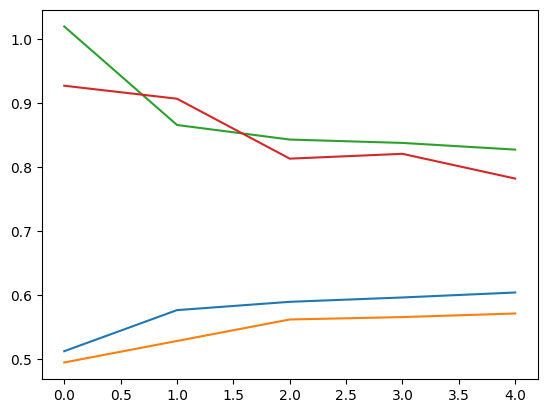

In [ ]:
# plot accrucay by epoch
import matplotlib.pyplot as plt
plt.plot(history['accuracy'])
plt.plot(history['val_accuracy'])
plt.plot(history['loss'])
plt.plot(history['val_loss'])